In [1]:
# Cell 1 — imports & notebook setup
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")

# ensure project root (one level up from notebooks/) is importable
sys.path.append(os.path.abspath(".."))

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# Cell 2 — load dataset and train/test split
from src.data_utils import load_housing, get_split

X, y = load_housing()
X_train, X_test, y_train, y_test = get_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (16512, 8) (16512,)
Test : (4128, 8) (4128,)


In [ ]:
# Cell 3 — helper functions
from src.attacks import label_flip, outlier_injection
from src.models import train_model, evaluate
import joblib, math

def run_attack_and_eval(attack_name, attack_kwargs, model_name="linear"):
    # apply attack to a fresh copy of training data
    if attack_name == "label_flip":
        Xp, yp = label_flip(X_train, y_train, **attack_kwargs)
    elif attack_name == "outlier":
        # for outlier injection we support passing k or a fraction
        if "fraction" in attack_kwargs:
            k = int(len(X_train) * attack_kwargs["fraction"])
            Xp, yp = outlier_injection(X_train, y_train, k=k, feature_scale=attack_kwargs.get("feature_scale",10), target_scale=attack_kwargs.get("target_scale",20), random_state=RANDOM_STATE)
        else:
            Xp, yp = outlier_injection(X_train, y_train, **attack_kwargs)
    else:
        raise ValueError("unknown attack")

    # train model on poisoned data
    model = train_model(model_name, Xp, yp)

    # evaluate on clean test set
    metrics = evaluate(model, X_test, y_test)
    return Xp, yp, model, metrics

In [ ]:
# Cell 4 — baseline (no attack) check
model_clean = train_model("linear", X_train, y_train)
metrics_clean = evaluate(model_clean, X_test, y_test)
metrics_clean

{'rmse': 0.7455813830127763,
 'r2': 0.575787706032451,
 'predictions': array([0.71912284, 1.76401657, 2.70965883, ..., 4.46877017, 1.18751119,
        2.00940251], shape=(4128,))}

In [ ]:
# Cell 5 — label_flip sweep
fractions = [0.01, 0.05, 0.1, 0.2]
results_label = []

for frac in fractions:
    Xp, yp, model, metrics = run_attack_and_eval("label_flip", {"fraction": frac, "bias": 10.0})
    results_label.append({"attack":"label_flip", "fraction": frac, "rmse": metrics["rmse"], "r2": metrics["r2"], "n_train": len(Xp)})
    # save poisoned dataset
    os.makedirs("../data/poisoned", exist_ok=True)
    fname = f"../data/poisoned/label_flip_frac{int(frac*100)}.csv"
    pd.concat([Xp.reset_index(drop=True), yp.reset_index(drop=True)], axis=1).to_csv(fname, index=False)

pd.DataFrame(results_label)

,attack,fraction,rmse,r2,n_train
0,label_flip,0.01,0.751791,0.568692,16512
1,label_flip,0.05,0.895056,0.388644,16512
2,label_flip,0.10,1.244706,-0.182297,16512
3,label_flip,0.20,2.137793,-2.487582,16512


In [ ]:
# Cell 6 — outlier_injection sweep (use fraction to determine k)
fractions = [0.01, 0.05, 0.1]  # fewer steps for outliers
results_outlier = []

for frac in fractions:
    k = int(len(X_train) * frac)
    Xp, yp, model, metrics = run_attack_and_eval("outlier", {"fraction": frac, "feature_scale": 10, "target_scale": 30})
    results_outlier.append({"attack":"outlier_injection", "fraction": frac, "k": k, "rmse": metrics["rmse"], "r2": metrics["r2"], "n_train": len(Xp)})
    # save poisoned dataset
    os.makedirs("../data/poisoned", exist_ok=True)
    fname = f"../data/poisoned/outlier_frac{int(frac*100)}.csv"
    pd.concat([Xp.reset_index(drop=True), yp.reset_index(drop=True)], axis=1).to_csv(fname, index=False)

pd.DataFrame(results_outlier)

,attack,fraction,k,rmse,r2,n_train
0,outlier_injection,0.01,165,0.862101,0.432835,16677
1,outlier_injection,0.05,825,1.036353,0.180387,17337
2,outlier_injection,0.10,1651,1.122566,0.038351,18163


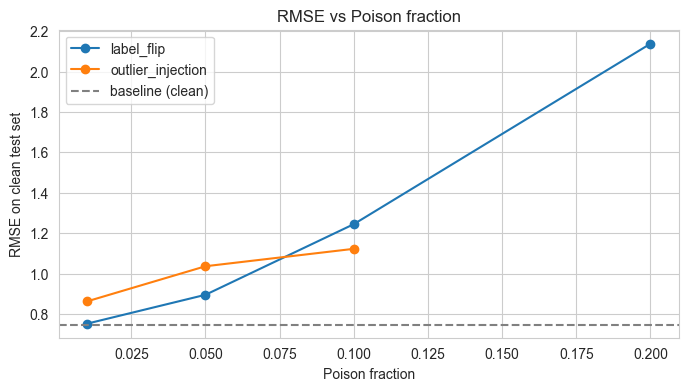

,attack,fraction,rmse,r2,n_train
0,label_flip,0.01,0.751791,0.568692,16512
1,label_flip,0.05,0.895056,0.388644,16512
2,label_flip,0.10,1.244706,-0.182297,16512
3,label_flip,0.20,2.137793,-2.487582,16512


,attack,fraction,k,rmse,r2,n_train
0,outlier_injection,0.01,165,0.862101,0.432835,16677
1,outlier_injection,0.05,825,1.036353,0.180387,17337
2,outlier_injection,0.10,1651,1.122566,0.038351,18163


In [ ]:
# Cell 7 — summarize and plot
df_label = pd.DataFrame(results_label)
df_out = pd.DataFrame(results_outlier)

# Plot label flip
plt.figure(figsize=(8,4))
plt.plot(df_label['fraction'], df_label['rmse'], marker='o', label='label_flip')
plt.plot(df_out['fraction'], df_out['rmse'], marker='o', label='outlier_injection')
plt.axhline(metrics_clean["rmse"], color='gray', linestyle='--', label='baseline (clean)')
plt.xlabel("Poison fraction")
plt.ylabel("RMSE on clean test set")
plt.title("RMSE vs Poison fraction")
plt.legend()
plt.grid(True)
plt.show()

# display dataframes
display(df_label)
display(df_out)

In [ ]:
# Cell 8 — save results to CSV
os.makedirs("../results", exist_ok=True)
pd.concat([df_label.assign(attack="label_flip"), df_out.assign(attack="outlier_injection")], ignore_index=True).to_csv("../results/attacks_summary.csv", index=False)
print("Saved ../results/attacks_summary.csv")

Saved ../results/attacks_summary.csv
